***Descripción del proyecto***

Analisis de eventos para una empresa emergente que vende productos alimenticios

<span style='color:dark '> Objetivo principal </span>: Investigar el comportamiento del usuario para la aplicación de la empresa.


<span style='color:dark'> Descripción de los datos: </span>
Cada entrada de registro es una acción de usuario o un evento.

EventName — nombre del evento

DeviceIDHash — identificador de usuario único

EventTimestamp — hora del evento

ExpId — número de experimento: 246 y 247 son los grupos de control, 248 es el grupo de prueba


## Informacion y librerias

En este paso se cargan las librerias y bases de datos que vamos a utilizar para el analisis:

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
from scipy import stats as st   
import math as mth
import datetime as dt
import numpy as np
import seaborn as sns
from plotly import graph_objects as go

In [2]:
data=pd.read_csv('/datasets/logs_exp_us.csv',delimiter='\t+', dtype={'EventName': 'category'}, )
data.head()

/tmp/ipykernel_24/2607522087.py:1: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  data=pd.read_csv('/datasets/logs_exp_us.csv',delimiter='\t+', dtype={'EventName': 'category'}, )


,EventName,DeviceIDHash,EventTimestamp,ExpId
0,MainScreenAppear,4575588528974610257,1564029816,246
1,MainScreenAppear,7416695313311560658,1564053102,246
2,PaymentScreenSuccessful,3518123091307005509,1564054127,248
3,CartScreenAppear,3518123091307005509,1564054127,248
4,PaymentScreenSuccessful,6217807653094995999,1564055322,248


## Procesamiento de informacion

En esta seccion evaluamos la estructura de los datos en terminos de duplicados, tipo y nombres de las columnas.

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 244126 entries, 0 to 244125
Data columns (total 4 columns):
 #   Column          Non-Null Count   Dtype   
---  ------          --------------   -----   
 0   EventName       244126 non-null  category
 1   DeviceIDHash    244126 non-null  int64   
 2   EventTimestamp  244126 non-null  int64   
 3   ExpId           244126 non-null  int64   
dtypes: category(1), int64(3)
memory usage: 5.8 MB


Se cambian nombres y estilos:

In [4]:
data['event_date']= pd.to_datetime(data['EventTimestamp'], unit='s')
data=data.rename(columns={"EventName": "event_name", "DeviceIDHash": "device_id","ExpId":"test_id"})

Se agregan columnas en base a la fecha del evento para el analisis :

In [5]:
data['month']=data['event_date'].dt.month
data['day']=data['event_date'].dt.day
data['date_no_hours']=pd.to_datetime(data['event_date']).dt.date
data['year']=data['event_date'].dt.year

### Validacion de duplicados

In [6]:
data[data.duplicated(keep=False)].count()

event_name        768
device_id         768
EventTimestamp    768
test_id           768
event_date        768
month             768
day               768
date_no_hours     768
year              768
dtype: int64

Procedemos eliminar los datos duplicados:

In [7]:
data=data.drop_duplicates()
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 243713 entries, 0 to 244125
Data columns (total 9 columns):
 #   Column          Non-Null Count   Dtype         
---  ------          --------------   -----         
 0   event_name      243713 non-null  category      
 1   device_id       243713 non-null  int64         
 2   EventTimestamp  243713 non-null  int64         
 3   test_id         243713 non-null  int64         
 4   event_date      243713 non-null  datetime64[ns]
 5   month           243713 non-null  int64         
 6   day             243713 non-null  int64         
 7   date_no_hours   243713 non-null  object        
 8   year            243713 non-null  int64         
dtypes: category(1), datetime64[ns](1), int64(6), object(1)
memory usage: 17.0+ MB


Despues de la depuracion de 244,126 ahora quedan 243,713 registros unicos.

### Validacion de valores ausentes

Validamos valores NaN en la tabla:

In [8]:
data.isnull().values.any().any()

False

### Vista general

Se visualiza la tabla final y adicionalmente la cantidad de eventos y usuarios de la base:

In [9]:
print('Existen', data['event_name'].nunique(),'niveles de etapas')
print('Existen', data['device_id'].nunique(),'tipos de dispositivos')
display(data.head())

Existen 5 niveles de etapas
Existen 7551 tipos de dispositivos


,event_name,device_id,EventTimestamp,test_id,event_date,month,day,date_no_hours,year
0,MainScreenAppear,4575588528974610257,1564029816,246,2019-07-25 04:43:36,7,25,2019-07-25,2019
1,MainScreenAppear,7416695313311560658,1564053102,246,2019-07-25 11:11:42,7,25,2019-07-25,2019
2,PaymentScreenSuccessful,3518123091307005509,1564054127,248,2019-07-25 11:28:47,7,25,2019-07-25,2019
3,CartScreenAppear,3518123091307005509,1564054127,248,2019-07-25 11:28:47,7,25,2019-07-25,2019
4,PaymentScreenSuccessful,6217807653094995999,1564055322,248,2019-07-25 11:48:42,7,25,2019-07-25,2019


### Analisis de la informacion

En esta seccion analizaremos embudo de ventas para identificar la cantidad de usuarios que llega a cada etapa y cuellos de botella en cada uno. Las etapas son:
1. MainScreenAppear
2. Tutorial
3. OffersScreenAppear
4. CartScreenAppear
5. PaymentScreenSuccessfull

In [83]:
display(data['event_name'].unique())

['MainScreenAppear', 'PaymentScreenSuccessful', 'CartScreenAppear', 'OffersScreenAppear', 'Tutorial']
Categories (5, object): ['MainScreenAppear', 'PaymentScreenSuccessful', 'CartScreenAppear', 'OffersScreenAppear', 'Tutorial']

In [84]:
visitors=data[data['event_name']=='MainScreenAppear'].shape[0]
tutorial=data[data['event_name']=='Tutorial'].shape[0]
oferta=data[data['event_name']=='OffersScreenAppear'].shape[0]
carrito=data[data['event_name']=='CartScreenAppear'].shape[0]
compra=data[data['event_name']=='PaymentScreenSuccessful'].shape[0]

In [85]:
fig = go.Figure(go.Funnel(
    y = ["Visitantes","pantalla de productos","Producto añadido al carrito","Pagado","tutorial"],
    x = [visitors, oferta,  carrito, compra,tutorial]
    ))
fig.show()

Visitas convertidas: 
De los 119k que ingresan menos de la mitad mira la oferta con apenas un 39,4% del total.

Oferta:
Sin embargo aquellos que si lo hacen mas del 91.2% selecciona un producto para comprar. Lo que quiere decir que la mayoria de clientes al momento de ingresar a la pagina de productos realmente encuentra lo que estan buscando o un producto llamo mucho su atencion. Ambas opciones nos dicen que la oferta que se muestra es potente.

Compras exitosas:
Ahora al momento de ejecutar la comprar de 43k caemos a 34k, casi 10k se pierde en el siguiente paso que corresponde al 20%. Puede existir varias razones entre las mas comunes, problemas con el motor de cobros que usa la pagina, pocas opciones de pago. 
Visualizar el tutorial puede ser una accion que salte al momento de ingresar a la pagina o bien al final de la compra. De cualquier manera no es un factor ligado a ninguno de los pasos.

Tutorial:
Visualizar el tutorial puede ser una accion que salte al momento de ingresar a la pagina o bien al final de la compra. De cualquier manera no es un factor ligado a ninguno de los pasos sino mas bien un extra para que el clientre conozca sobre los productos.
Posiblemente el video es muy largo o el inicio aburrido y por eso el % tan bajo de personas que lo ven.

<div class="alert alert-warning">
<b>⚠️ Comentario del revisor:</b>
    
Te aconsejo para no olvidar sobre los nombres cuando muestres informacion en los graficos

#### Antiguedad

En esta seccion se valida la distribucion del periodo, maximos y minimos.

(array([18102., 18104., 18106., 18108., 18109., 18111., 18113., 18115.]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

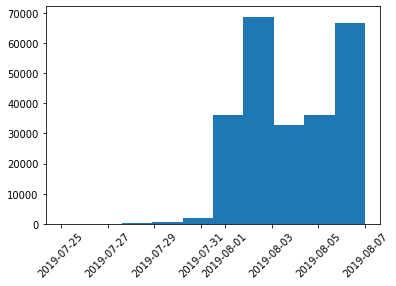

In [86]:
plt.hist(data['date_no_hours'])
plt.xticks(rotation=45)

In [87]:
print('Fecha maxima',data['event_date'].max())
print('Fecha minima',data['event_date'].min())

Fecha maxima 2019-08-07 21:15:17
Fecha minima 2019-07-25 04:43:36


Como se observa en el grafico los dias de julio casi no detallan informacion, por lo que tomaremos la informacion desde agosto. Observaremos como cambian los % en el siguiente grafico:

In [88]:
data_filter=data[data['event_date']>'2019-08-01']

In [89]:
visitors2=data_filter[data_filter['event_name']=='MainScreenAppear'].shape[0]
tutorial2=data_filter[data_filter['event_name']=='Tutorial'].shape[0]
oferta2=data_filter[data_filter['event_name']=='OffersScreenAppear'].shape[0]
carrito2=data_filter[data_filter['event_name']=='CartScreenAppear'].shape[0]
compra2=data_filter[data_filter['event_name']=='PaymentScreenSuccessful'].shape[0]

In [90]:
fig = go.Figure(go.Funnel(
    y = ["Visitantes","pantalla de productos","Producto añadido al carrito","Pagado","tutorial"],
    x = [visitors2, oferta2, carrito2,compra2,tutorial2]
    ))
fig.show()

Una vez que hemos excluido las fechas que no tiene la data completa la cifra baja de 119.101k a 117.328 es decir unas 1.7 visitas aproximandamente fueron excluidas.
Si embargo los % de conversion no se ven alterados , suben un 0.02% en todas las etapas.

### Prueba A/A/B

A los diseñadores les gustaría cambiar las fuentes de toda la aplicación pero los gerentes temen que los usuarios piensen que el nuevo diseño es intimidante. Por ello, deciden tomar una decisión basada en los resultados de un test A/A/B. donde dos mantienen las mismas fuentes y la tercera cambia por la nueva.
Primeramente vamos a cuantificar la cantidad por cada uno de los tres grupos:

In [91]:
data_filter.pivot_table(index='test_id',values='event_name',aggfunc='count')

,event_name
test_id,
246,79302
247,77022
248,84563


#### Validacion de diferencias entre grupos

para esto vamos a calcular la proporcion de clientes que compran en los grupos 246 y 247 para validar si hay una diferencia estadistica.
En el caso del grupo 246 de 37676 clientes que miran la pagina inicial, 11852 compran un producto.
Mientras que del grupo 247 de 39039 visitantes 9981 compran

In [92]:
table=data_filter.pivot_table(index='event_name',columns='test_id',values='device_id',aggfunc='nunique').reset_index()
table

test_id,event_name,246,247,248
0,CartScreenAppear,1266,1238,1230
1,MainScreenAppear,2450,2476,2493
2,OffersScreenAppear,1542,1520,1531
3,PaymentScreenSuccessful,1200,1158,1181
4,Tutorial,278,283,279


In [93]:
from scipy import stats as st
import numpy as np
import math as mth

alpha = .05 # nivel de significación

successes = np.array([1200, 1158])
trials = np.array([2450, 2476])

p1 = successes[0]/trials[0]
p2 = successes[1]/trials[1]
p_combined = (successes[0] + successes[1]) / (trials[0] + trials[1])
difference = p1 - p2

#estadística en desviaciones estándar de la distribución normal estándar
z_value = difference / mth.sqrt(p_combined * (1 - p_combined) * (1/trials[0] + 1/trials[1]))
distr = st.norm(0, 1) 

p_value = (1 - distr.cdf(abs(z_value))) * 2
print('proporción de éxito en el primer 246: ',p1)
print('proporción de éxito en el primer 247: ',p2)
print('proporción de éxito en el dataset unido:', p_combined)
print('la diferencia entre las proporciones de los datasets', difference)
print('p-value: ', p_value)

if (p_value < alpha):
    print("Rechazar la hipótesis nula: hay una diferencia significativa entre las proporciones")
else:
    print("No se pudo rechazar la hipótesis nula: no hay razón para pensar que las proporciones son diferentes")

proporción de éxito en el primer 246:  0.4897959183673469
proporción de éxito en el primer 247:  0.4676898222940226
proporción de éxito en el dataset unido: 0.47868453105968334
la diferencia entre las proporciones de los datasets 0.02210609607332431
p-value:  0.12044299485641763
No se pudo rechazar la hipótesis nula: no hay razón para pensar que las proporciones son diferentes


El % de conversion del total de usuarios que visitan la pagina difiere en un 2% aproximadamente entre e grupo 246 y el grupo 247.
Adicionalmente con un nivel de significancia del 0.05 vemos quye el valor p es 0.12 lo cual confirma que las proporciones de los grupos no son estadisticamente diferentes.

#### Evento mas popular

podemos validar los eventos mas populares de cada grupo:

In [94]:
data.pivot_table(index='event_name',columns='test_id',values='device_id',aggfunc='count').reset_index()

test_id,event_name,246,247,248
0,CartScreenAppear,14798,12548,15322
1,MainScreenAppear,38249,39677,41175
2,OffersScreenAppear,14904,15341,16563
3,PaymentScreenSuccessful,11912,10039,12167
4,Tutorial,318,345,355


Vamos a crear las listas de la cantidad de eventos por dia para cada grupo y luego sacar la difenrencia entre cada uno dependiendo del tipo de evento. ´Primero creamos los 3 grupos separados:

In [95]:
grupo1=data_filter[data_filter['test_id']==246]
grupo2=data_filter[data_filter['test_id']==247]
grupo3=data_filter[data_filter['test_id']==248]

Luego procedemos a sacar las proporciones por cada evento 
1. Pantalla principal

In [96]:
mainscreen1 = grupo1[grupo1['event_name']=='MainScreenAppear'].groupby('date_no_hours', as_index=False).agg({'device_id' : pd.Series.nunique})
visitas1=mainscreen1['device_id'].tolist()
mainscreen2 = grupo2[grupo2['event_name']=='MainScreenAppear'].groupby('date_no_hours', as_index=False).agg({'device_id' : pd.Series.nunique})
visitas2=mainscreen2['device_id'].tolist()
mainscreen3 = grupo3[grupo3['event_name']=='MainScreenAppear'].groupby('date_no_hours', as_index=False).agg({'device_id' : pd.Series.nunique})
visitas3=mainscreen3['device_id'].tolist()

Pantalla de ofertas de productos:

In [97]:
offerscreen1 = grupo1[grupo1['event_name']=='OffersScreenAppear'].groupby('date_no_hours', as_index=False).agg({'device_id' : pd.Series.nunique})
ofertas1=offerscreen1['device_id'].tolist()
offerscreen2 = grupo2[grupo2['event_name']=='OffersScreenAppear'].groupby('date_no_hours', as_index=False).agg({'device_id' : pd.Series.nunique})
ofertas2=offerscreen2['device_id'].tolist()
offerscreen3 = grupo3[grupo3['event_name']=='OffersScreenAppear'].groupby('date_no_hours', as_index=False).agg({'device_id' : pd.Series.nunique})
ofertas3=offerscreen3['device_id'].tolist()

Carrito de compras:

In [98]:
cart1 = grupo1[grupo1['event_name']=='CartScreenAppear'].groupby('date_no_hours', as_index=False).agg({'device_id' : pd.Series.nunique})
carrito1=cart1['device_id'].tolist()
cart2 = grupo2[grupo2['event_name']=='CartScreenAppear'].groupby('date_no_hours', as_index=False).agg({'device_id' : pd.Series.nunique})
carrito2=cart2['device_id'].tolist()
cart3 = grupo3[grupo3['event_name']=='CartScreenAppear'].groupby('date_no_hours', as_index=False).agg({'device_id' : pd.Series.nunique})
carrito3=cart3['device_id'].tolist()

compras efectivas:

In [99]:
purchase1 = grupo1[grupo1['event_name']=='PaymentScreenSuccessful'].groupby('date_no_hours', as_index=False).agg({'device_id' : pd.Series.nunique})
compras1=purchase1['device_id'].tolist()
purchase2 = grupo2[grupo2['event_name']=='PaymentScreenSuccessful'].groupby('date_no_hours', as_index=False).agg({'device_id' : pd.Series.nunique})
compras2=purchase2['device_id'].tolist()
purchase3 = grupo3[grupo3['event_name']=='PaymentScreenSuccessful'].groupby('date_no_hours', as_index=False).agg({'device_id' : pd.Series.nunique})
compras3=purchase3['device_id'].tolist()

Tutorial

In [100]:
tut1 = grupo1[grupo1['event_name']=='MainScreenAppear'].groupby('date_no_hours', as_index=False).agg({'device_id' : pd.Series.nunique})
tutorial1=tut1['device_id'].tolist()
tut2 = grupo2[grupo2['event_name']=='MainScreenAppear'].groupby('date_no_hours', as_index=False).agg({'device_id' : pd.Series.nunique})
tutorial2=tut2['device_id'].tolist()
tut3 = grupo3[grupo3['event_name']=='MainScreenAppear'].groupby('date_no_hours', as_index=False).agg({'device_id' : pd.Series.nunique})
tutorial3=tut3['device_id'].tolist()

#### Aplicacion prueba de que las poblaciones son iguales

En esta seccion creamos una funcion para validar las proporciones de los eventos del grupo 246 y 247 y posteriormente el grupo 246 contra el grupo 248

In [101]:
def prueba(sample_1,sample_2):
    alpha = 0.05 
    results = st.mannwhitneyu(sample_1, sample_2)
    if results.pvalue < alpha:
        return("Rechazamos la hipótesis nula, el p-value es", results.pvalue)
    else:
        return("No rechazamos la hipótesis nula, el p-value es", results.pvalue) 

In [102]:
prueba(visitas1,visitas2)

('No rechazamos la hipótesis nula, el p-value es', 0.3828671328671329)

In [103]:
prueba(ofertas1,ofertas2)

('No rechazamos la hipótesis nula, el p-value es', 0.9490036864430583)

In [104]:
prueba(carrito1,carrito2)

('No rechazamos la hipótesis nula, el p-value es', 0.40519960201333727)

In [105]:
prueba(compras1,compras2)

('No rechazamos la hipótesis nula, el p-value es', 0.33523441379595964)

In [106]:
prueba(tutorial1,tutorial2)

('No rechazamos la hipótesis nula, el p-value es', 0.3828671328671329)

Validacion de grupos 246 -247 (A/A): Comparando la cantidad de eventos por dia segun el tipo de evento se comprueba que todas las proporciones son iguales en todos los niveles del embudo.
Ambas muestras no presentan variaciones lo cual es correcto porque mantienen la misma fuente de diseño.
Ahora vamos a comprar con el grupo al cual se le mostro la fuente cambiada.

In [107]:
prueba(visitas1,visitas3)

('No rechazamos la hipótesis nula, el p-value es', 0.45571095571095577)

In [108]:
prueba(ofertas1,ofertas2)

('No rechazamos la hipótesis nula, el p-value es', 0.9490036864430583)

In [109]:
prueba(carrito1,carrito3)

('No rechazamos la hipótesis nula, el p-value es', 0.8982154826854546)

In [110]:
prueba(compras1,compras3)

('No rechazamos la hipótesis nula, el p-value es', 0.8478409541795124)

In [111]:
prueba(tutorial1,tutorial3)

('No rechazamos la hipótesis nula, el p-value es', 0.45571095571095577)

### Conclusiones

Dentro del ciclo de compra de la pagina podemos resaltar lo siguiente:
    De los visitantes iniciales solo el 40% llega a la pagina de oferta de productos.
    Sin embargo aquellos que llegan a este paso pasan en un 91% al carrito de compras lo que quiere decir que la oferta esta ajustada a la necesidad del cliente.
    Para las compras efetivacs tenemos un 80% de efectividad por lo que se deben revisar puntos de mejora como opciones para el pago, pasarela de cobros entre otros.
    
En base a la pruebas ejecutadas A/A/B  el cambio de diseño no afecta el comportamiento actual de los clientes en ningun de las etapas del flujo. Se recomienda de igual manera mantener un grupo de control por unos 3 meses para medir mejoras.